In [266]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import NaturalEarthFeature
from matplotlib import colors
from functools import reduce
import cftime as cf
import regionmask
import geopandas as gp
import matplotlib.patheffects as pe
import pooch
from IPython.display import Markdown

# Is there a difference between total sectoral withdrawal in the LND and ROF components?
While the demand for irrigation and other sectors is computed in the land component (LND) of the model, the supply come from the routing component (ROF), and notably from the river network storage.
Since the LND and ROF components have different grids, there is a need to properly connect the demand and supply part through the coupler. This is done through a mapping procedure from LND -> ROF fluxes.

Another important challenge to consider, is that the multiple ROF cells which overlap with a given LND cell, may have very different amount of water stored in the river (VOLR).
It makes sense therefore to distribute the demand load (from LND cell), onto the ROF cells in proportion to their water storage. 
If we take more water from ROF cells with higher VOLR, we are more likely to avoid the situation in which we try to withdraw more that it is available in any given ROF cell.
In this case we will not be invoking the protection algorithm which provides missing water from ocean, an unrealistic situation to be avoided.

The currently implemented mapping procedure goes as follow:
1) Normalize a given LND cell demand flux by the available VOLR in that LND cell
2) Mapping this VOLR-normalized demand flux to the ROF grid
3) Convert the VOLR-normalized demand flux back to normal flux on the ROF grid

If the remapping procedure is correct, we should expect that when we aggregate at global or continental level, the total actual withdrawal seen by the LND and ROF model should be the same.
In this notebook I am testing this hypothesis, first for irrigation, and then for other sectors which used the same remaping procedure.


In [281]:
# unit transform constants
seconds_per_day = 86400.0
avg_days_per_month_year_2000 = 366.0/12
mm_per_s_to_mm_per_month = seconds_per_day*avg_days_per_month_year_2000

m_to_mm = 10**(3)
mm_to_m = 10**(-3)

# Since ROF provides the withdrawal fluxes as m3/s, we need to divide by each grid area to obtain the fluxes as mm/s
# The MOSART provides 3 outputs for area. From these 3, I found that only 'areatotal2' provides the right magnitude of withdrawal fluxes when compared to the LND fluxes (but I am not 100% if this is the right area values to use)
area_rof       =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/area/area_rof.nc', decode_times=False)['area'].values.flatten() # runoff grid area
areatotal_rof  =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/area/areatotal_rof.nc', decode_times=False)['areatotal'].values.flatten() # basin upstream areatotal
areatotal2_rof =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/area/areatotal2_rof.nc', decode_times=False)['areatotal2'].values.flatten() # computed basin upstream areatotal
area_lnd =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/area/area_lnd.nc', decode_times=False)['area'].values.flatten()*(10**6) # transform from km2 to m2

mask_lnd  = xr.open_dataset('/glade/u/home/staranu/useful_data/landmask.nc', decode_times=False)['landmask'].values.flatten()
lndfract = xr.open_dataset('/glade/u/home/staranu/useful_data/landfrac.nc', decode_times=False)['landfrac'].values.flatten()
area_lnd = area_lnd*lndfract

mask_rof = xr.open_dataset('/glade/u/home/staranu/useful_data/rof_mask.nc', decode_times=False)['mask'].values.flatten()
area_rof = np.where((mask_rof == 1) | (mask_rof == 3), area_rof, np.nan)

print("Total land covered area in MOSART is: " +str(np.round(np.nansum(area_rof)/(10**12), 0)) + " millions km2") 
print("Total land covered area in CLM is: " +str(np.round(np.nansum(area_lnd)/(10**12), 0)) + " millions km2") 

mask_rof = np.where(mask_rof == 2, mask_rof, 1)
mask_rof = np.where(mask_rof == 1, mask_rof, np.nan)

rof_m3_per_s_to_km3_per_month = seconds_per_day*avg_days_per_month_year_2000/(10**9)
lnd_mm_per_s_to_km3_per_month = mm_per_s_to_mm_per_month*mm_to_m*area_lnd/(10**9)

Total land covered area in MOSART is: 132.0 millions km2
Total land covered area in CLM is: 149.0 millions km2


In [268]:
# Load lon and lat coordinates for lnd and rof components
lnd_lon = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc')['lon'].values
lnd_lat = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc')['lat'].values

rof_lon = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc')['lon'].values
rof_lat = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc')['lat'].values

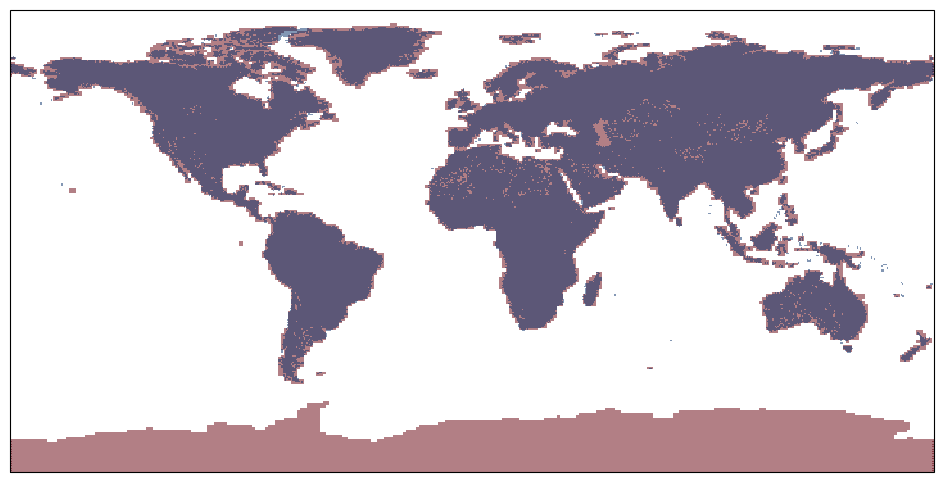

In [269]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

# Assume lnd_lon, lnd_lat, mask_lnd, rof_lon, rof_lat, mask_rof are known

# Plotting the masks
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('Reds')
ax.pcolormesh(lnd_lon, lnd_lat, mask_lnd.reshape((lnd_lat.shape[0], lnd_lon.shape[0])), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=0, vmax=1, alpha=0.5)
cmap = plt.get_cmap('Blues')
ax.pcolormesh(rof_lon, rof_lat, mask_rof.reshape((rof_lat.shape[0], rof_lon.shape[0])), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=0, vmax=1, alpha =0.5)

# Remove gridlines and labels
#ax.gridlines(draw_labels=False)
# ax.outline_patch.set_visible(False)

plt.show()


In [260]:
np.abs(np.nansum(mask_lnd*lndfract)-np.nansum(mask_lnd))/np.nansum(mask_lnd)*100

9.223652598141948

11.409395973154362

In [285]:
# Load the irrigation data from land model
# The data is obtained from a simulation with: irrigate=.true. and limit_irrigation_if_rof_enabled=.true.
# Transform from mm/s to mm/year
# We get mm/year instead of mm/month because we also sum over 12 months of year 2000
lnd_irrig_withd = (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc', decode_times=False)['QIRRIG_FROM_SURFACE']).sum(dim='time')
lnd_irrig_withd.values = (lnd_irrig_withd.values.flatten()*lnd_mm_per_s_to_km3_per_month).reshape((lnd_lat.shape[0], lnd_lon.shape[0]))

print("Total global LND irrigation withdrawal is: " + str(np.round(np.nansum(lnd_irrig_withd),0)) + " km3/year")

Total global LND irrigation withdrawal is: 581.0 km3/year


In [284]:
# Load the irrigation data from routing model (mosart)
# The data is obtained from a simulation with: irrigate=.true. and limit_irrigation_if_rof_enabled=.true.
rof_irrig_withd = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QIRRIG_ACTUAL'].sum(dim='time')

# Transform from m3/s to mm/year
# We get mm/year instead of mm/month because in the previous step we do the sum over 12 months of year 2000
rof_irrig_withd.values = (rof_irrig_withd.values.flatten()*rof_m3_per_s_to_km3_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))

print("Total global ROF irrigation withdrawal is: " + str(np.round(np.nansum(rof_irrig_withd),0)) + " km3/year")

Total global ROF irrigation withdrawal is: -581.0 km3/year


In [289]:
# Comparison at continent level

file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

# Initialize some xarrays used for storage and computation
delta_irrig_lnd_vs_rof = lnd_irrig_withd.copy(deep=True)*0.0
relative_delta_irrig_lnd_vs_rof = lnd_irrig_withd.copy(deep=True)*0.0
array_ones = lnd_irrig_withd.copy(deep=True)*0.0 + 1.0

# Generate a mask for each continent for both lnd and rof components
continents_lnd = regionmask.mask_geopandas(continents, lnd_lon, lnd_lat)
continents_rof = regionmask.mask_geopandas(continents, rof_lon, rof_lat)

# Each continent gets has its own individual index from 0 to 7
continent_index = np.arange(0,8)

# Comparison at continent level
# Find the absolute and relative difference in irrigation amount between lnd and routing component at each basin level
for continent in range(np.max(continent_index)+1): # loop over each continent
    continent_lnd_irrig_withd = np.nansum(lnd_irrig_withd.where(continents_lnd == continent)) # for given continent compute total withdrawal for LND component
    continent_rof_irrig_withd = (-1.0)*np.nansum(rof_irrig_withd.where(continents_rof == continent)) # for given continent compute total withdrawal for ROF component
    
    if continent != 7: # no withdrawal in Antarctica
        print("For " + str(continents.CONTINENT[continent]) + " total LND irrigation is " + str(np.round(continent_lnd_irrig_withd,1)) + " km3/year, while total ROF irrigation is " + str(np.round(continent_rof_irrig_withd,1)) + " km3/year.")
    
    delta = continent_lnd_irrig_withd - continent_rof_irrig_withd # compute absolute difference in withdrawal amount for given continent
    delta_irrig_lnd_vs_rof = delta_irrig_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*delta).fillna(0) # add this continent difference in withdrawal to the map (masked by continent map)
    
    if continent != 7: # no withdrawal in Antarctica
        relative_delta_irrig_lnd_vs_rof = relative_delta_irrig_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*(delta/continent_lnd_irrig_withd)*100).fillna(0) # compute relative difference for given continent and add its value to the final map
      
    if continent != 7: # no withdrawal in Antarctica   
        print("Absolute difference is [LND - ROF]: " + str(np.round(delta,1)) + " km3/year")
        print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((delta/continent_lnd_irrig_withd)*100),1)) + " %")
        print()
        
print("For the entire globe, total lnd irrigation is " + str(np.round(np.nansum(lnd_irrig_withd),1)) + " km3/year, while total rof irrigation is " + str(np.round(np.abs(np.nansum(rof_irrig_withd)),1)) + " km3/year.")
print("Absolute difference is [LND - ROF]: " + str(np.round(np.nansum(lnd_irrig_withd) - np.abs(np.nansum(rof_irrig_withd)),1)) + " km3/year")
print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((np.nansum(lnd_irrig_withd) - np.abs(np.nansum(rof_irrig_withd)))/np.nansum(lnd_irrig_withd))*100,1)) + " %")
print()

For Asia total LND irrigation is 387.3 km3/year, while total ROF irrigation is 386.7 km3/year.
Absolute difference is [LND - ROF]: 0.6 km3/year
Relative difference is: [LND - ROF]/[LND]: 0.2 %

For North America total LND irrigation is 74.8 km3/year, while total ROF irrigation is 75.3 km3/year.
Absolute difference is [LND - ROF]: -0.5 km3/year
Relative difference is: [LND - ROF]/[LND]: 0.7 %

For Europe total LND irrigation is 34.6 km3/year, while total ROF irrigation is 35.0 km3/year.
Absolute difference is [LND - ROF]: -0.5 km3/year
Relative difference is: [LND - ROF]/[LND]: 1.3 %

For Africa total LND irrigation is 39.3 km3/year, while total ROF irrigation is 41.0 km3/year.
Absolute difference is [LND - ROF]: -1.7 km3/year
Relative difference is: [LND - ROF]/[LND]: 4.3 %

For South America total LND irrigation is 20.6 km3/year, while total ROF irrigation is 21.0 km3/year.
Absolute difference is [LND - ROF]: -0.4 km3/year
Relative difference is: [LND - ROF]/[LND]: 1.9 %

For Oceania 

In [162]:
# Load the irrigation data from routing model (mosart), but this time the QIRRIG_FROM_COUPLER
# The data is obtained from a simulation with: irrigate=.true. and limit_irrigation_if_rof_enabled=.true.
rof_irrig_withd_from_coupler = xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/rof/hist/selected_data/aggregated_data/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QIRRIG_FROM_COUPLER'].sum(dim='time')

# Transform from m3/s to mm/year
# We get mm/year instead of mm/month because in the previous step we do the sum over 12 months of year 2000
rof_irrig_withd_from_coupler.values = (rof_irrig_withd_from_coupler.values.flatten()*rof_m3_per_s_to_mm_per_s*mm_per_s_to_mm_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))


In [163]:
# Compare global actual and from the coupler irrigation withdrawal (ROF component)
print("Global actual irrigation withdrawal [ROF]: " + str(np.round(np.nansum(rof_irrig_withd),0)) + " mm/year")
print("Global irrigation withdrawal from the coupler [ROF]: " + str(np.round(np.nansum(rof_irrig_withd_from_coupler),0)) + " mm/year")

Global actual irrigation withdrawal [ROF]: -53534.0 mm/year
Global irrigation withdrawal from the coupler [ROF]: -53534.0 mm/year


In [303]:
# Load the domestic withdrawal data:
lnd_dom_withd = (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/lnd/hist/selected_data/aggregated_data/monthly/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc', decode_times=False)['DOM_ACTUAL_WITHD']).sum(dim='time')
lnd_dom_withd.values = (lnd_dom_withd.values.flatten()*lnd_mm_per_s_to_km3_per_month).reshape((lnd_lat.shape[0], lnd_lon.shape[0]))
                 
rof_dom_withd =  (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/rof/hist/selected/aggregated/mon/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QDOM_ACTUAL_WITHD']).sum(dim='time')
rof_dom_withd.values = (rof_dom_withd.values.flatten()*rof_m3_per_s_to_km3_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))

print("Total global LND domestic withdrawal is: " + str(np.round(np.nansum(lnd_dom_withd),0)) + " km3/year")
print("Total global ROF domestic withdrawal is: " + str(np.round(np.nansum(rof_dom_withd),0)) + " km3/year")

Total global LND domestic withdrawal is: 341.0 km3/year
Total global ROF domestic withdrawal is: -340.0 km3/year


In [305]:
# Comparison at continent level

file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

# Initialize some xarrays used for storage and computation
delta_dom_lnd_vs_rof = lnd_dom_withd.copy(deep=True)*0.0
relative_delta_dom_lnd_vs_rof = lnd_dom_withd.copy(deep=True)*0.0
array_ones = lnd_dom_withd.copy(deep=True)*0.0 + 1.0

# Generate a mask for each continent for both lnd and rof components
continents_lnd = regionmask.mask_geopandas(continents, lnd_lon, lnd_lat)
continents_rof = regionmask.mask_geopandas(continents, rof_lon, rof_lat)

# Each continent gets has its own individual index from 0 to 7
continent_index = np.arange(0,8)

# Comparison at continent level
# Find the absolute and relative difference in domestic withdrawal amount between lnd and routing component at each basin level
for continent in range(np.max(continent_index)+1): # loop over each continent
    continent_lnd_dom_withd = np.nansum(lnd_dom_withd.where(continents_lnd == continent)) # for given continent compute total withdrawal for LND component
    continent_rof_dom_withd = (-1.0)*np.nansum(rof_dom_withd.where(continents_rof == continent)) # for given continent compute total withdrawal for ROF component
    
    if continent != 7: # no withdrawal in Antarctica
        print("For " + str(continents.CONTINENT[continent]) + " total lnd domestic withdrawal is " + str(np.round(continent_lnd_dom_withd,0)) + " km3/year, while total rof domestic withdrawal is " + str(np.round(continent_rof_dom_withd,0)) + " km3/year.")
    
    delta = continent_lnd_dom_withd - continent_rof_dom_withd # compute absolute difference in withdrawal amount for given continent
    delta_dom_lnd_vs_rof = delta_dom_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*delta).fillna(0) # add this continent difference in withdrawal to the map (masked by continent map)
    
    if continent != 7: # no withdrawal in Antarctica
        relative_delta_dom_lnd_vs_rof = relative_delta_dom_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*(delta/continent_lnd_dom_withd)*100).fillna(0) # compute relative difference for given continent and add its value to the final map
      
    if continent != 7: # no withdrawal in Antarctica   
        print("Absolute difference is [LND - ROF]: " + str(np.round(delta,0)) + " km3/year")
        print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((delta/continent_lnd_dom_withd)*100),1)) + " %")
        print()

print("For the entire globe, total lnd domestic withdrawal is " + str(np.round(np.nansum(lnd_dom_withd),0)) + " km3/year, while total rof domestic withdrawal is " + str(np.round(np.abs(np.nansum(rof_dom_withd)),0)) + " km3/year.")
print("Absolute difference is [LND - ROF]: " + str(np.round(np.nansum(lnd_dom_withd) - np.abs(np.nansum(rof_dom_withd)),0)) + " km3/year")
print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((np.nansum(lnd_dom_withd) - np.abs(np.nansum(rof_dom_withd)))/np.nansum(lnd_dom_withd))*100,1)) + " %")
print()

For Asia total lnd domestic withdrawal is 146.0 km3/year, while total rof domestic withdrawal is 145.0 km3/year.
Absolute difference is [LND - ROF]: 1.0 km3/year
Relative difference is: [LND - ROF]/[LND]: 0.9 %

For North America total lnd domestic withdrawal is 68.0 km3/year, while total rof domestic withdrawal is 70.0 km3/year.
Absolute difference is [LND - ROF]: -1.0 km3/year
Relative difference is: [LND - ROF]/[LND]: 2.1 %

For Europe total lnd domestic withdrawal is 62.0 km3/year, while total rof domestic withdrawal is 62.0 km3/year.
Absolute difference is [LND - ROF]: -0.0 km3/year
Relative difference is: [LND - ROF]/[LND]: 0.3 %

For Africa total lnd domestic withdrawal is 23.0 km3/year, while total rof domestic withdrawal is 23.0 km3/year.
Absolute difference is [LND - ROF]: -0.0 km3/year
Relative difference is: [LND - ROF]/[LND]: 0.5 %

For South America total lnd domestic withdrawal is 25.0 km3/year, while total rof domestic withdrawal is 25.0 km3/year.
Absolute difference is

In [307]:
# Load the livestock withdrawal data:
lnd_liv_withd = (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/lnd/hist/selected_data/aggregated_data/monthly/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc', decode_times=False)['LIV_ACTUAL_WITHD']).sum(dim='time')
lnd_liv_withd.values = (lnd_liv_withd.values.flatten()*lnd_mm_per_s_to_km3_per_month).reshape((lnd_lat.shape[0], lnd_lon.shape[0]))
                 
rof_liv_withd =  (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/rof/hist/selected/aggregated/mon/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QLIV_ACTUAL_WITHD']).sum(dim='time')
rof_liv_withd.values = (rof_liv_withd.values.flatten()*rof_m3_per_s_to_km3_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))

print("Total global LND livestock withdrawal is: " + str(np.round(np.nansum(lnd_liv_withd),0)) + " km3/year")
print("Total global ROF livestock withdrawal is: " + str(np.round(np.nansum(rof_liv_withd),0)) + " km3/year")

Total global LND livestock withdrawal is: 98.0 km3/year
Total global ROF livestock withdrawal is: -97.0 km3/year


In [308]:
# Comparison at continent level

file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

# Initialize some xarrays used for storage and computation
delta_liv_lnd_vs_rof = lnd_liv_withd.copy(deep=True)*0.0
relative_delta_liv_lnd_vs_rof = lnd_liv_withd.copy(deep=True)*0.0
array_ones = lnd_liv_withd.copy(deep=True)*0.0 + 1.0

# Generate a mask for each continent for both lnd and rof components
continents_lnd = regionmask.mask_geopandas(continents, lnd_lon, lnd_lat)
continents_rof = regionmask.mask_geopandas(continents, rof_lon, rof_lat)

# Each continent gets has its own individual index from 0 to 7
continent_index = np.arange(0,8)

# Comparison at continent level
# Find the absolute and relative difference in livestock withdrawal amount between lnd and routing component at each basin level
for continent in range(np.max(continent_index)+1): # loop over each continent
    continent_lnd_liv_withd = np.nansum(lnd_liv_withd.where(continents_lnd == continent)) # for given continent compute total withdrawal for LND component
    continent_rof_liv_withd = (-1.0)*np.nansum(rof_liv_withd.where(continents_rof == continent)) # for given continent compute total withdrawal for ROF component
    
    if continent != 7: # no withdrawal in Antarctica
        print("For " + str(continents.CONTINENT[continent]) + " total LND livestock withdrawal is " + str(np.round(continent_lnd_liv_withd,1)) + " km3/year, while total ROF livestock withdrawal is " + str(np.round(continent_rof_liv_withd,1)) + " km3/year.")
    
    delta = continent_lnd_liv_withd - continent_rof_liv_withd # compute absolute difference in withdrawal amount for given continent
    delta_liv_lnd_vs_rof = delta_liv_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*delta).fillna(0) # add this continent difference in withdrawal to the map (masked by continent map)
    
    if continent != 7: # no withdrawal in Antarctica
        relative_delta_liv_lnd_vs_rof = relative_delta_liv_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*(delta/continent_lnd_liv_withd)*100).fillna(0) # compute relative difference for given continent and add its value to the final map
      
    if continent != 7: # no withdrawal in Antarctica   
        print("Absolute difference is [LND - ROF]: " + str(np.round(delta,1)) + " km3/year")
        print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((delta/continent_lnd_liv_withd)*100),1)) + " %")
        print()
        
print("For the entire globe, total LND livestock withdrawal is " + str(np.round(np.nansum(lnd_liv_withd),1)) + " km3/year, while total ROF livestock withdrawal is " + str(np.round(np.abs(np.nansum(rof_liv_withd)),1)) + " km3/year.")
print("Absolute difference is [LND - ROF]: " + str(np.round(np.nansum(lnd_liv_withd) - np.abs(np.nansum(rof_liv_withd)),1)) + " km3/year")
print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((np.nansum(lnd_liv_withd) - np.abs(np.nansum(rof_liv_withd)))/np.nansum(lnd_liv_withd))*100,1)) + " %")
print()

For Asia total LND livestock withdrawal is 54.1 km3/year, while total ROF livestock withdrawal is 53.6 km3/year.
Absolute difference is [LND - ROF]: 0.5 km3/year
Relative difference is: [LND - ROF]/[LND]: 0.9 %

For North America total LND livestock withdrawal is 11.6 km3/year, while total ROF livestock withdrawal is 11.6 km3/year.
Absolute difference is [LND - ROF]: 0.0 km3/year
Relative difference is: [LND - ROF]/[LND]: 0.2 %

For Europe total LND livestock withdrawal is 7.7 km3/year, while total ROF livestock withdrawal is 7.7 km3/year.
Absolute difference is [LND - ROF]: -0.0 km3/year
Relative difference is: [LND - ROF]/[LND]: 0.5 %

For Africa total LND livestock withdrawal is 10.1 km3/year, while total ROF livestock withdrawal is 9.9 km3/year.
Absolute difference is [LND - ROF]: 0.2 km3/year
Relative difference is: [LND - ROF]/[LND]: 2.2 %

For South America total LND livestock withdrawal is 5.9 km3/year, while total ROF livestock withdrawal is 5.7 km3/year.
Absolute difference i

In [309]:
# Load the thermoelectric withdrawal data:
lnd_elec_withd = (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/lnd/hist/selected_data/aggregated_data/monthly/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc', decode_times=False)['ELEC_ACTUAL_WITHD']).sum(dim='time')
lnd_elec_withd.values = (lnd_elec_withd.values.flatten()*lnd_mm_per_s_to_km3_per_month).reshape((lnd_lat.shape[0], lnd_lon.shape[0]))
                 
rof_elec_withd =  (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/rof/hist/selected/aggregated/mon/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QELEC_ACTUAL_WITHD']).sum(dim='time')
rof_elec_withd.values = (rof_elec_withd.values.flatten()*rof_m3_per_s_to_km3_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))

print("Total global LND thermoelectric withdrawal is: " + str(np.round(np.nansum(lnd_elec_withd),0)) + " km3/year")
print("Total global ROF thermoelectric withdrawal is: " + str(np.round(np.nansum(rof_elec_withd),0)) + " km3/year")

Total global LND thermoelectric withdrawal is: 409.0 km3/year
Total global ROF thermoelectric withdrawal is: -408.0 km3/year


In [310]:
# Comparison at continent level

file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

# Initialize some xarrays used for storage and computation
delta_elec_lnd_vs_rof = lnd_elec_withd.copy(deep=True)*0.0
relative_delta_elec_lnd_vs_rof = lnd_elec_withd.copy(deep=True)*0.0
array_ones = lnd_elec_withd.copy(deep=True)*0.0 + 1.0

# Generate a mask for each continent for both lnd and rof components
continents_lnd = regionmask.mask_geopandas(continents, lnd_lon, lnd_lat)
continents_rof = regionmask.mask_geopandas(continents, rof_lon, rof_lat)

# Each continent gets has its own individual index from 0 to 7
continent_index = np.arange(0,8)

# Comparison at continent level
# Find the absolute and relative difference in thermoelectric withdrawal amount between lnd and routing component at each basin level
for continent in range(np.max(continent_index)+1): # loop over each continent
    continent_lnd_elec_withd = np.nansum(lnd_elec_withd.where(continents_lnd == continent)) # for given continent compute total withdrawal for LND component
    continent_rof_elec_withd = (-1.0)*np.nansum(rof_elec_withd.where(continents_rof == continent)) # for given continent compute total withdrawal for ROF component
    
    if continent != 7: # no withdrawal in Antarctica
        print("For " + str(continents.CONTINENT[continent]) + " total LND thermoelectric withdrawal is " + str(np.round(continent_lnd_elec_withd,1)) + " mm/year, while total ROF thermoelectric withdrawal is " + str(np.round(continent_rof_elec_withd,1)) + " mm/year.")
    
    delta = continent_lnd_elec_withd - continent_rof_elec_withd # compute absolute difference in withdrawal amount for given continent
    delta_elec_lnd_vs_rof = delta_elec_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*delta).fillna(0) # add this continent difference in withdrawal to the map (masked by continent map)
    
    if continent != 7: # no withdrawal in Antarctica
        relative_delta_elec_lnd_vs_rof = relative_delta_elec_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*(delta/continent_lnd_elec_withd)*100).fillna(0) # compute relative difference for given continent and add its value to the final map
      
    if continent != 7: # no withdrawal in Antarctica   
        print("Absolute difference is [LND - ROF]: " + str(np.round(delta,1)) + " mm/year")
        print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((delta/continent_lnd_elec_withd)*100),1)) + " %")
        print()
        
print("For the entire globe, total LND thermoelectric withdrawal is " + str(np.round(np.nansum(lnd_elec_withd),1)) + " mm/year, while total ROF thermoelectric withdrawal is " + str(np.round(np.abs(np.nansum(rof_elec_withd)),1)) + " mm/year.")
print("Absolute difference is [LND - ROF]: " + str(np.round(np.nansum(lnd_elec_withd) - np.abs(np.nansum(rof_elec_withd)),1)) + " mm/year")
print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((np.nansum(lnd_elec_withd) - np.abs(np.nansum(rof_elec_withd)))/np.nansum(lnd_elec_withd))*100,1)) + " %")
print()  

For Asia total LND thermoelectric withdrawal is 91.8 mm/year, while total ROF thermoelectric withdrawal is 89.8 mm/year.
Absolute difference is [LND - ROF]: 2.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 2.1 %

For North America total LND thermoelectric withdrawal is 204.6 mm/year, while total ROF thermoelectric withdrawal is 206.0 mm/year.
Absolute difference is [LND - ROF]: -1.4 mm/year
Relative difference is: [LND - ROF]/[LND]: 0.7 %

For Europe total LND thermoelectric withdrawal is 98.5 mm/year, while total ROF thermoelectric withdrawal is 98.7 mm/year.
Absolute difference is [LND - ROF]: -0.2 mm/year
Relative difference is: [LND - ROF]/[LND]: 0.2 %

For Africa total LND thermoelectric withdrawal is 3.5 mm/year, while total ROF thermoelectric withdrawal is 3.4 mm/year.
Absolute difference is [LND - ROF]: 0.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 1.1 %

For South America total LND thermoelectric withdrawal is 2.6 mm/year, while total ROF thermoelectric withdraw

In [313]:
# Load the manufacturing withdrawal data:
lnd_mfc_withd = (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/lnd/hist/selected_data/aggregated_data/monthly/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc', decode_times=False)['MFC_ACTUAL_WITHD']).sum(dim='time')
lnd_mfc_withd.values = (lnd_mfc_withd.values.flatten()*lnd_mm_per_s_to_km3_per_month).reshape((lnd_lat.shape[0], lnd_lon.shape[0]))
                 
rof_mfc_withd =  (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/rof/hist/selected/aggregated/mon/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QMFC_ACTUAL_WITHD']).sum(dim='time')
rof_mfc_withd.values = (rof_mfc_withd.values.flatten()*rof_m3_per_s_to_km3_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))

print("Total global LND manufacturing withdrawal is: " + str(np.round(np.nansum(lnd_mfc_withd),0)) + " km3/year")
print("Total global ROF manufacturing withdrawal is: " + str(np.round(np.nansum(rof_mfc_withd),0)) + " km3/year")

Total global LND manufacturing withdrawal is: 226.0 km3/year
Total global ROF manufacturing withdrawal is: -225.0 km3/year


In [315]:
# Comparison at continent level

file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

# Initialize some xarrays used for storage and computation
delta_mfc_lnd_vs_rof = lnd_mfc_withd.copy(deep=True)*0.0
relative_delta_mfc_lnd_vs_rof = lnd_mfc_withd.copy(deep=True)*0.0
array_ones = lnd_mfc_withd.copy(deep=True)*0.0 + 1.0

# Generate a mask for each continent for both lnd and rof components
continents_lnd = regionmask.mask_geopandas(continents, lnd_lon, lnd_lat)
continents_rof = regionmask.mask_geopandas(continents, rof_lon, rof_lat)

# Each continent gets has its own individual index from 0 to 7
continent_index = np.arange(0,8)

# Comparison at continent level
# Find the absolute and relative difference in manufacturing withdrawal amount between lnd and routing component at each basin level
for continent in range(np.max(continent_index)+1): # loop over each continent
    continent_lnd_mfc_withd = np.nansum(lnd_mfc_withd.where(continents_lnd == continent)) # for given continent compute total withdrawal for LND component
    continent_rof_mfc_withd = (-1.0)*np.nansum(rof_mfc_withd.where(continents_rof == continent)) # for given continent compute total withdrawal for ROF component
    
    if continent != 7: # no withdrawal in Antarctica
        print("For " + str(continents.CONTINENT[continent]) + " total LND manufacturing withdrawal is " + str(np.round(continent_lnd_mfc_withd,1)) + " mm/year, while total ROF manufacturing withdrawal is " + str(np.round(continent_rof_mfc_withd,1)) + " mm/year.")
    
    delta = continent_lnd_mfc_withd - continent_rof_mfc_withd # compute absolute difference in withdrawal amount for given continent
    delta_mfc_lnd_vs_rof = delta_mfc_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*delta).fillna(0) # add this continent difference in withdrawal to the map (masked by continent map)
    
    if continent != 7: # no withdrawal in Antarctica
        relative_delta_mfc_lnd_vs_rof = relative_delta_mfc_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*(delta/continent_lnd_mfc_withd)*100).fillna(0) # compute relative difference for given continent and add its value to the final map
      
    if continent != 7: # no withdrawal in Antarctica   
        print("Absolute difference is [LND - ROF]: " + str(np.round(delta,1)) + " mm/year")
        print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((delta/continent_lnd_mfc_withd)*100),1)) + " %")
        print()
        
print("For the entire globe, total LND manufacturing withdrawal is " + str(np.round(np.nansum(lnd_mfc_withd),1)) + " mm/year, while total ROF manufacturing withdrawal is " + str(np.round(np.abs(np.nansum(rof_mfc_withd)),1)) + " mm/year.")
print("Absolute difference is [LND - ROF]: " + str(np.round(np.nansum(lnd_mfc_withd) - np.abs(np.nansum(rof_mfc_withd)),1)) + " mm/year")
print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((np.nansum(lnd_mfc_withd) - np.abs(np.nansum(rof_mfc_withd)))/np.nansum(lnd_mfc_withd))*100,1)) + " %")
print()  

For Asia total LND manufacturing withdrawal is 100.0 mm/year, while total ROF manufacturing withdrawal is 98.5 mm/year.
Absolute difference is [LND - ROF]: 1.5 mm/year
Relative difference is: [LND - ROF]/[LND]: 1.5 %

For North America total LND manufacturing withdrawal is 31.5 mm/year, while total ROF manufacturing withdrawal is 32.0 mm/year.
Absolute difference is [LND - ROF]: -0.4 mm/year
Relative difference is: [LND - ROF]/[LND]: 1.3 %

For Europe total LND manufacturing withdrawal is 70.4 mm/year, while total ROF manufacturing withdrawal is 70.5 mm/year.
Absolute difference is [LND - ROF]: -0.1 mm/year
Relative difference is: [LND - ROF]/[LND]: 0.2 %

For Africa total LND manufacturing withdrawal is 5.2 mm/year, while total ROF manufacturing withdrawal is 5.1 mm/year.
Absolute difference is [LND - ROF]: 0.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 0.5 %

For South America total LND manufacturing withdrawal is 11.7 mm/year, while total ROF manufacturing withdrawal is 11.6

In [320]:
# Load the mining withdrawal data:
lnd_min_withd = (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/lnd/hist/selected_data/aggregated_data/monthly/selected_variables.ctsm_escomp_irrig_rof_limited.clm2.h0.2000.nc', decode_times=False)['MIN_ACTUAL_WITHD']).sum(dim='time')
lnd_min_withd.values = (lnd_min_withd.values.flatten()*lnd_mm_per_s_to_km3_per_month).reshape((lnd_lat.shape[0], lnd_lon.shape[0]))
                 
rof_min_withd =  (xr.open_dataset('/glade/scratch/staranu/archive/ctsm_for_pull_request_test1_2/rof/hist/selected/aggregated/mon/selected_variables.ctsm_escomp_irrig_rof_limited.mosart.h0.2000.nc', decode_times=False)['QMIN_ACTUAL_WITHD']).sum(dim='time')
rof_min_withd.values = (rof_min_withd.values.flatten()*rof_m3_per_s_to_km3_per_month).reshape((rof_lat.shape[0], rof_lon.shape[0]))

print("Total global LND mining withdrawal is: " + str(np.round(np.nansum(lnd_min_withd),0)) + " km3/year")
print("Total global ROF mining withdrawal is: " + str(np.round(np.nansum(rof_min_withd),0)) + " km3/year")

Total global LND mining withdrawal is: 20.0 km3/year
Total global ROF mining withdrawal is: -20.0 km3/year


In [321]:
# Comparison at continent level

file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)

# Initialize some xarrays used for storage and computation
delta_min_lnd_vs_rof = lnd_min_withd.copy(deep=True)*0.0
relative_delta_min_lnd_vs_rof = lnd_min_withd.copy(deep=True)*0.0
array_ones = lnd_min_withd.copy(deep=True)*0.0 + 1.0

# Generate a mask for each continent for both lnd and rof components
continents_lnd = regionmask.mask_geopandas(continents, lnd_lon, lnd_lat)
continents_rof = regionmask.mask_geopandas(continents, rof_lon, rof_lat)

# Each continent gets has its own individual index from 0 to 7
continent_index = np.arange(0,8)

# Comparison at continent level
# Find the absolute and relative difference in mining withdrawal amount between lnd and routing component at each basin level
for continent in range(np.max(continent_index)+1): # loop over each continent
    continent_lnd_min_withd = np.nansum(lnd_min_withd.where(continents_lnd == continent)) # for given continent compute total withdrawal for LND component
    continent_rof_min_withd = (-1.0)*np.nansum(rof_min_withd.where(continents_rof == continent)) # for given continent compute total withdrawal for ROF component
    
    if continent != 7: # no withdrawal in Antarctica
        print("For " + str(continents.CONTINENT[continent]) + " total LND mining withdrawal is " + str(np.round(continent_lnd_min_withd,1)) + " mm/year, while total ROF mining withdrawal is " + str(np.round(continent_rof_min_withd,1)) + " mm/year.")
    
    delta = continent_lnd_min_withd - continent_rof_min_withd # compute absolute difference in withdrawal amount for given continent
    delta_min_lnd_vs_rof = delta_min_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*delta).fillna(0) # add this continent difference in withdrawal to the map (masked by continent map)
    
    if continent != 7: # no withdrawal in Antarctica
        relative_delta_min_lnd_vs_rof = relative_delta_min_lnd_vs_rof + (array_ones.where(continents_lnd == continent)*(delta/continent_lnd_min_withd)*100).fillna(0) # compute relative difference for given continent and add its value to the final map
      
    if continent != 7: # no withdrawal in Antarctica   
        print("Absolute difference is [LND - ROF]: " + str(np.round(delta,1)) + " mm/year")
        print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((delta/continent_lnd_min_withd)*100),1)) + " %")
        print()
        
print("For the entire globe, total LND mining withdrawal is " + str(np.round(np.nansum(lnd_min_withd),1)) + " mm/year, while total ROF mining withdrawal is " + str(np.round(np.abs(np.nansum(rof_min_withd)),1)) + " mm/year.")
print("Absolute difference is [LND - ROF]: " + str(np.round(np.nansum(lnd_min_withd) - np.abs(np.nansum(rof_min_withd)),1)) + " mm/year")
print("Relative difference is: [LND - ROF]/[LND]: " + str(np.round(np.abs((np.nansum(lnd_min_withd) - np.abs(np.nansum(rof_min_withd)))/np.nansum(lnd_min_withd))*100,1)) + " %")
print()  

For Asia total LND mining withdrawal is 9.0 mm/year, while total ROF mining withdrawal is 8.9 mm/year.
Absolute difference is [LND - ROF]: 0.1 mm/year
Relative difference is: [LND - ROF]/[LND]: 1.0 %

For North America total LND mining withdrawal is 4.4 mm/year, while total ROF mining withdrawal is 4.5 mm/year.
Absolute difference is [LND - ROF]: -0.1 mm/year
Relative difference is: [LND - ROF]/[LND]: 1.3 %

For Europe total LND mining withdrawal is 4.4 mm/year, while total ROF mining withdrawal is 4.4 mm/year.
Absolute difference is [LND - ROF]: -0.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 0.4 %

For Africa total LND mining withdrawal is 0.9 mm/year, while total ROF mining withdrawal is 0.9 mm/year.
Absolute difference is [LND - ROF]: 0.0 mm/year
Relative difference is: [LND - ROF]/[LND]: 1.7 %

For South America total LND mining withdrawal is 1.1 mm/year, while total ROF mining withdrawal is 1.0 mm/year.
Absolute difference is [LND - ROF]: 0.0 mm/year
Relative difference i